# CREPE!
In this notebook I'll be trying out different ways of using the `CREPE` model offered by Essentia. This is a Pitch Estimation model, so there are a ton of things that can be done with this and it could be quite valuable for determining similarities between songs!

### Imports and Setup

In [49]:
import math
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from essentia.standard import (MonoLoader, PitchCREPE)

TRACK_PATH = "/Users/nico/Desktop/CIIC/CAPSTONE/essentia_demo/src/audio/dataset_flac/01 - AAA Powerline.flac"
MODEL_PATH = "/Users/nico/Desktop/CIIC/CAPSTONE/essentia_demo/src/models/crepe-full-1.pb"

TRACK_MONO = MonoLoader(filename=TRACK_PATH, sampleRate=16000, resampleQuality=0)()
model      = PitchCREPE(graphFilename=MODEL_PATH)


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/Users/nico/Desktop/CIIC/CAPSTONE/essentia_demo/src/models/crepe-full-1.pb`


In [ ]:
time, frequency, confidence, activations = model(TRACK_MONO)



print(len(frequency), frequency)
print(np.mean(frequency, axis=0))



TypeError: 'tuple' object is not callable

In [ ]:
print(len(activations[0]))

for i in range(50):
    print(np.argmax(activations[i]), frequency[i])


360
149 177.75037
19 39.57224
149 177.43346
52 57.765778
58 62.172432
58 61.93588
58 61.35121
58 61.538837
56 60.555145
48 55.706493
47 54.16282
43 52.010544
48 55.063084
48 55.033073
48 54.804203
48 55.08671
48 55.55925
48 55.086018
47 53.997433
47 54.231827
48 55.488426
48 55.25431
48 54.885838
47 54.574806
48 55.271423
47 54.758167
46 53.525414
46 53.81932
47 54.771698
48 55.316822
48 55.279423
43 52.220547
43 51.88274
48 54.824963
48 55.430347
47 54.442123
38 49.45711
0 32.039665
0 31.909454
0 32.066994
43 51.862934
48 55.311005
48 55.325848
48 55.049953
48 55.120724
48 55.166767
48 55.431316
48 55.183807
2 32.66514
40 50.47275
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360
360


In [ ]:
print(type(time), time.shape)
print(type(frequency), frequency.shape)
print(type(confidence), confidence.shape)
print(type(activations), activations.shape)


print("Pitch Mean",     np.mean(frequency, axis=0))
print("Pitch Variance", np.var(frequency, axis=0))
print("Pitch Range", f"[{min(frequency)}, {max(frequency)}]")


print(frequency.shape)

int_freq = frequency.astype(int)
counts   = Counter(int_freq)
print(counts)


<class 'numpy.ndarray'> (25201,)
<class 'numpy.ndarray'> (25201,)
<class 'numpy.ndarray'> (25201,)
<class 'numpy.ndarray'> (25201, 360)
Pitch Mean 165.52248
Pitch Variance 15294.658
Pitch Range [31.86103057861328, 1870.0380859375]
(25201,)
Counter({55: 3687, 54: 3465, 329: 900, 32: 851, 328: 790, 220: 774, 327: 700, 219: 563, 330: 547, 56: 505, 52: 478, 326: 392, 221: 345, 183: 334, 57: 315, 184: 311, 51: 305, 218: 279, 331: 255, 53: 251, 325: 218, 185: 202, 182: 197, 61: 194, 110: 185, 109: 182, 222: 179, 217: 169, 324: 166, 111: 158, 112: 155, 58: 147, 246: 134, 275: 128, 186: 126, 223: 125, 224: 113, 180: 108, 276: 107, 165: 103, 31: 102, 62: 98, 247: 96, 245: 95, 323: 94, 216: 92, 36: 91, 181: 91, 211: 86, 277: 84, 213: 81, 274: 76, 208: 75, 210: 73, 215: 68, 280: 67, 196: 65, 279: 65, 59: 64, 167: 64, 166: 63, 187: 63, 248: 62, 278: 62, 188: 61, 60: 60, 164: 59, 273: 59, 212: 59, 44: 58, 214: 56, 225: 54, 332: 52, 293: 52, 49: 51, 46: 49, 114: 49, 33: 48, 209: 48, 281: 47, 272: 47

In [ ]:

def build_pitch_profile(activation_matrix):
    """Builds a Pitch Profile (Histogram) based on the Activation Matrix retrieved
    from the CREPE Model Output. We iterate through each 10ms frame saved in the
    Activation Matrix and get the index for the highest value in the 360D Bins.
    """
    activation_counter = Counter()
    for activation_bin in activation_matrix:
        bin_index      = np.argmax(activation_bin)
        activation_counter[bin_index] += 1

    return activation_counter


def build_weighted_pitch_profile(activation_matrix):
    """Builds a weighted Pitch Profile (Histogram) by summing
    the activation vectors for all frames.
    """
    # Initialize a 360-dimensional array for the histogram
    weighted_hist = np.zeros(360)
    for activation_bin in activation_matrix:
        weighted_hist += activation_bin  # element-wise addition

    # Normalize the histogram to form a probability distribution
    weighted_hist /= np.sum(weighted_hist)
    return weighted_hist


def build_pitch_profile_freq(frequency):
    """Same as the first, but instead we turn this into 20-Cent Steps (1/5 Semitone)"""
    freq_counter  = Counter()
    for freq in frequency:
        # MIDI Note based on 20-Cent Steps (Not a Semitone). The 69 * 5 is because
        # on MIDI Notes, the A4 Reference note is 69 (Reference : https://newt.phys.unsw.edu.au/jw/notes.html)
        midi_note = math.floor((60 * math.log2(freq)) + (69 * 5))
        freq_counter[midi_note] += 1

    return freq_counter


act_counter    = build_pitch_profile(activations)
freq_counter   = build_pitch_profile_freq(frequency)
weighted_hist  = build_weighted_pitch_profile(activations)
print((act_counter))
print((freq_counter))



Counter({48: 4641, 47: 2350, 202: 1954, 203: 1800, 168: 1519, 167: 747, 152: 673, 0: 615, 43: 556, 153: 502, 201: 378, 187: 316, 169: 310, 177: 293, 49: 270, 51: 263, 52: 260, 46: 253, 58: 240, 188: 224, 151: 214, 108: 210, 107: 204, 42: 193, 165: 183, 164: 181, 109: 178, 143: 177, 190: 173, 178: 157, 2: 155, 50: 150, 157: 149, 189: 143, 110: 135, 154: 134, 170: 130, 166: 119, 163: 116, 53: 115, 186: 115, 3: 114, 179: 99, 193: 99, 144: 98, 231: 91, 191: 89, 171: 82, 122: 81, 158: 79, 185: 79, 1: 78, 192: 76, 228: 70, 111: 70, 162: 67, 204: 65, 229: 64, 155: 63, 161: 61, 142: 61, 227: 60, 44: 56, 59: 53, 55: 53, 148: 52, 176: 51, 172: 51, 38: 50, 13: 49, 33: 45, 156: 45, 45: 44, 149: 40, 29: 40, 180: 38, 182: 37, 57: 36, 147: 36, 12: 35, 184: 34, 32: 33, 200: 32, 4: 31, 37: 29, 183: 29, 124: 28, 112: 28, 293: 28, 28: 26, 83: 26, 150: 26, 175: 26, 173: 26, 132: 24, 181: 23, 15: 21, 14: 21, 121: 21, 23: 19, 54: 19, 129: 19, 56: 18, 133: 18, 160: 17, 106: 17, 199: 17, 136: 16, 27: 15, 62: 

[]

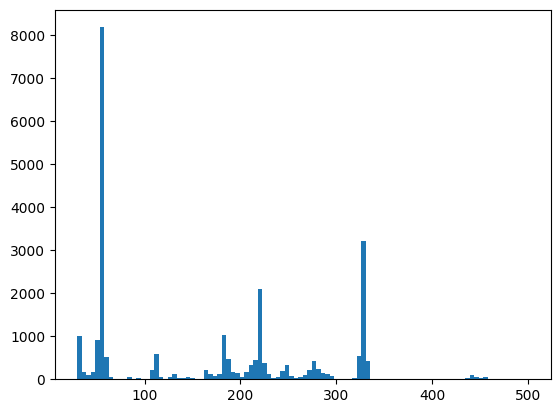

In [62]:
plt.hist(frequency, bins=100, range=[30, 500])
plt.plot()

[]

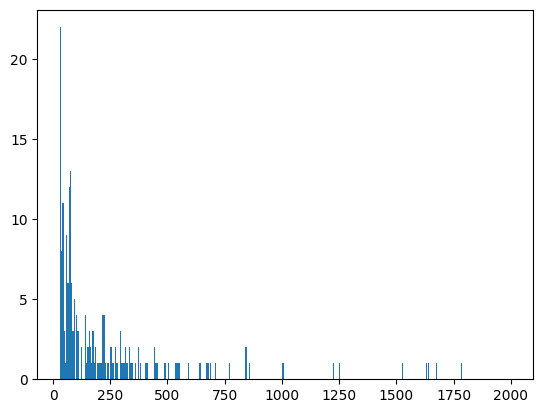

In [66]:
plt.hist(weighted_hist, bins=360, range=[30, 2000])
plt.plot()